In [369]:
%matplotlib inline

Urban Health in Barcelona 
======================

## Introduction


This project explores medical home visits in Barcelona between 2015 and now (end of 2018).
The main research questions revolve around how geography and urban features play a part in these medical visits?
In this part of the project, I have done a very hefty amount of data preprocessing and exploration, and build a few models to answer correlational questions.

In this section I will explore geographical patterns and urban correlations of pathologies from the home medical visits dataset from multiple analytical directions:
1. Heat–mapping pathologies 
    - Map all pathologies and find uniqueness of areas without medical incidents
    - Map specific common pathologies and find differences in coverage patterns
2. Flow Analysis: Time-lapse animated Heat-mapping – flows of pathologies
3. Prediction Modeling: Develop models predicting pathology type with using geographical information or not (only patient's age, number of visits and date-time data). I also use a decision-tree type classifier which inherently determines the order of importance of the parameters, revealing how to geographical features rank in terms of importance


The data comes from [Home Medical Visits](https://www.kaggle.com/HackandHealth/home-medical-visits-healthcare) dataset, which was released under [Hack&Health 2018](https://www.terrassa.cat/es/hack-health). 

# Notes

### CDA 
#### How is this data Biased? 
#### Other Methods
- Economic Data: Census 
- Spatial Regression
- Time-Fixed Model

Can I predict lower back pain by others complaining? 
use some pathology that shouldn't spread as a placebo test
- transform data into Zip codes, predict per zip code. Can I predict each neighborhoods instacnes of each disease? can I predict by closeby neighborhoods?

### Econometrics
- Build a story: Literature review
- Hausman Test between regressions
Run both and see if the coefficients change a lot 

# Data Preperation

### Importing libraries and data

In [370]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting
import seaborn as sns
#import editdistance
import os
sns.set(style="darkgrid")

In [17]:
# load csv into pandas, parse date column
df = pd.read_csv('./input/Hack2018_ES.csv', parse_dates=[9])

print("Dataset shape: {} rows, {} columns. \nExample of data rows:".format(len(df), len(df.columns)))
df.sample(5)

## Data Cleaning and Preprocessing

We have a dataset with 40k rows and 15 columns coming from the information collected of a Home Medical Services Company located in the metropolitan area of Barcelona (Spain).

From this dataset we can identify information:

1 - Info about the patient :

    Age - edad_valor
    Younger ( - 18 years) - menor

2- Medical information:

    Pathology - patologia
    number of home assistance - nasistencias

3 - Info about the visit:

    Date - fecha
    time delay of the visit - tiempo_demora
    Status of the visit: 1 Pending 2 Accepted 3 Rejected 4 Closed 5 Canceled 6 Incidence 7 Reassign 8 Duplicate

4 - Info about the location of the patient:

    City - poblacion
    City codification - id_poblacion
    ZIP code - cp
    Latitude of the address of the patient (with a randow offset) - latitude_corregida
    Longitude of the address of the patient (with a randow offset) - longitude_corregida
    Geopoint (latitude + longitude) with a randow offset) - Geopoint_corregido

    
First, I will translate column names from Spanish to English.
Original Column Names:
['estado', 'tiempo_demora', 'poblacion', 'id_poblacion', 'edad_valor',
'cp', 'latitude_corregida', 'longitud_corregida', 'patologia', 'Fecha',
'id_tipo', 'id_personal', 'nasistencias', 'menor',
'Geopoint_corregido']

English translation:
['visit_status','time_delay','city','city_id','patient_age','zipcode','lat','lon','pathology','date','id_type','id_personal','n_home_visits','is_patient_minor','geo_point']

In [4]:
# redefine column names from Spanish to English, based on descriptions in Dataset Page 
df.columns # list current column names for translation
new_colnames = ['status','time_delay','city','city_id','age',
                'zip','lat','lon','pathology','date','id_type',
                'id_personal','n_visits','minor_18','geopoint']
df.columns = new_colnames
df.sample(1)

,status,time_delay,city,city_id,age,zip,lat,lon,pathology,date,id_type,id_personal,n_visits,minor_18,geopoint
39036,5,60,Matadepera,8,1.0,8230.0,"41,61125752","2,037138673",VOMITOS,2017-02-20 18:36:00,1,29,1,1,POINT(2.0371386734664396 41.61125752178431)


Clean and list distinct pathologies found

In [5]:
# Patology Cleaning from ckroxigor (kaggle.com/ckroxigor)

def conversion(text):
    if text.startswith("amigdalitis aguda"): return "amigdalitis aguda"
    if text.startswith("consejo salud"): return "health consultation"
    if text.startswith("urticaria"): return "urticaria"
    if text == "miositis/ fibromialgia": return "miositis fibromialgia"
    if text.startswith("migra"): return "migraine"
    if text.startswith("herpes"): return "herpes"
    if text.startswith("fractura"): return "fractura"
    if text.startswith("fisura anal"): return "fisura anal"
    if text.startswith("amigdalitis"): return "amigdalitis"
    if text.startswith("ansiedad"): return "ansiedad"
    return text

def remove(text):
    for w in ['anonymxxx']:
        text = text.replace(w, ' ')
    return text

def clean_pathology(text):
    text = text.lower()
    text = remove(text)
    #for this analysis, we consolidate acute or non acute manifestation of the same disease
    text = text.split(" aguda")[0] 
    text = text.split(" con ")[0]
    text = text.split(" -")[0]
    text = text.split(" /")[0]
    text = text.split("llamar")[0]
    text = text.split("pc smc")[0]
    text = text.strip()
    text = text.replace('  ', ' ')
    text = conversion(text)
    text = ' '.join([t for t in text.split(' ') if len(t) > 0])
    return text

print("Cleaned names of pathologies. \nBefore cleaning, we had: {} pathologies".format(len(df.pathology.unique())))
df["pathology_original"] = df.pathology
cleaned = df.pathology.apply(clean_pathology)
print("After cleaning, consolidated into: {} pathologies".format(len(cleaned.unique())))
df['pathology'] = cleaned # add to df
#', '.join(cleaned.unique().tolist())

Cleaned names of pathologies. 
Before cleaning, we had: 462 pathologies
After cleaning, consolidated into: 237 pathologies


In [6]:
# Convert date column to datetime
df.date = pd.to_datetime(df.date)

# clean Lat and Lon fields: instead of commas, dots. 
print("Type and sample of Lat/Lon fields:\n", type(df.lon[1]), (df.lon[1]))
if type(df.lon[1]) == str:
    def convert_comma_to_dot(num):
        return float(num.replace(',','.'))
    df.lat = df.lat.apply(convert_comma_to_dot)
    df.lon = df.lon.apply(convert_comma_to_dot)
    print(df.lat.sample(1))

Type and sample of Lat/Lon fields:
 <class 'str'> 2,08933
36433    41.479517
Name: lat, dtype: float64


### Check Missing Data

In [7]:
# print overall data rows
print("We have total {} observations in our data. \nHere are columns with their amount of missing values:".format(len(df)))
# show missing data
missing = []
for column in df.columns:
    missing.append({'column': column, 'missing': df[column].isnull().sum()})
missing = pd.DataFrame.from_records(missing)
missing[missing.missing > 0]

We have total 40079 observations in our data. 
Here are columns with their amount of missing values:


,column,missing
4,age,57
5,zip,2


Let's clean the data out of these missing values

In [8]:
# Drop NAs
print("Dataset has {} rows (visits), {} with missing values".format(len(df), missing[missing.missing > 0].missing.sum()))
df = df.dropna()
print("\n Dropped NAs, now: ", df.dropna().shape)

Dataset has 40079 rows (visits), 59 with missing values

 Dropped NAs, now:  (40020, 16)


#### Clean Status field
The meaning of the status field is the following:

1.    Pending
2.    Accepted
3.    Rejected
4.    Closed
5.    Canceled
6.    Incidence
7.    Reassign
8.    Duplicate


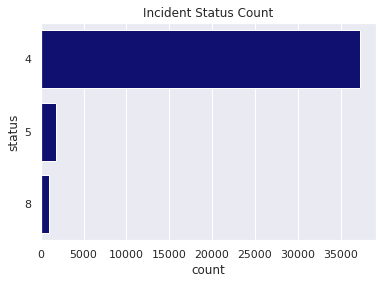

In [9]:
fig = sns.countplot(y="status", data=df, color="navy")
fig.set_title("Incident Status Count")
plt.show()

This shows that by bar most incidents were closed, with some incidents being cancelled (which we'd probably want to keep as the information in them might be still valuable, even if the patient backed out) and some duplicated ones. Since the duplicated ones are duplicates of data, it will skew the results, so I will drop it.
Cleaning the dataset from the "duplicate" calls, to not confound our distribution

In [10]:
print("Number of duplicates: {}".format(sum(df.status == 8)))
# keep only rows with status as not duplicate
df = df[df.status != 8]
print("Now cleaned dataset has {} observations".format(len(df)))

Number of duplicates: 999
Now cleaned dataset has 39021 observations


### Cleaning town IDs
There are two fields related to town data. 
Let's veriry that they correspond uniquely.

In [11]:
town_ids = df[['city', 'city_id']].drop_duplicates()
print("The same town may have different ids:")
#town_ids.city.sort_values()
#(town_ids[town_ids.city.apply(lambda name: name.strip().lower() == "barcelona")][:10])

The same town may have different ids:


In [12]:
towns_by_id = town_ids.groupby('city_id').count().reset_index()
duplicate_ids = towns_by_id[towns_by_id.city > 1].city_id.tolist()
print("Towns sharing ids:")
town_ids[town_ids.city_id.apply(lambda id: id in duplicate_ids)]

Towns sharing ids:


,city,city_id


In [13]:
# remove test row
df = df[df.city != 'CITY PROVES']

### Translate to English

In [14]:
from googletrans import Translator
translator = Translator()
# more complex yet more computationally efficient than tranlsating everything,
# would be to create a dictionary for the unique pathologies and use that to map
# create a list of distinct pathologies
unique_pathologies = df.pathology.unique()
# translate all distinct pathologies 
english_translations = [translator.translate(unique_pathologies[i], dest='en', src='es').text for i in range(len(unique_pathologies))]
for i in range(30):
    print("{} -> {}".format(unique_pathologies[i], english_translations[i]))

laringitis -> laryngitis
curas ulcera -> ulcer cures
cambio de sonda vesical -> change of bladder catheter
curas en cadera -> cures in hip
curas -> cures
fiebre -> fever
asteniameg -> asteniameg
fiebre. dolor garganta. -> fever. throat pain
inyectable cortisona -> injectable cortisone
inzitan -> inzitan
fortecortin -> fortecortin
cura -> cure
dolor abdominal -> abdominal pain
hipotension -> hypotension
infeccion resp -> infection resp
diarrea -> diarrhea
bronquitis -> bronchitis
viriasis -> viriasis
gripe -> flu
lumbalgia -> low back pain
health consultation -> health consultation
gastroenteritis -> stomach flu
hipertension arterial -> arterial hypertension
amigdalitis -> tonsillitis
mareo -> dizziness
odinofagia -> odynophagia
tos -> cough
astenia -> asthenia
bronquiolitis -> bronchiolitis
catarro -> cold


In [15]:
dict_pathologies = dict(zip(unique_pathologies, english_translations))

# fix some tranlsations
dict_pathologies['acufenostinnitus'] = 'tinnitus'
dict_pathologies['mas moquillos'] = 'canine distemper'
dict_pathologies['migra�a comun'] = 'migraine'
dict_pathologies['imp�tigo'] = 'impetigo'
dict_pathologies['gastroenteritis'] = 'gastroenteritis'
dict_pathologies['otitis'] = 'otalgia' # they mostly overlap: otitis is inflammatory
dict_pathologies['viriasis'] = 'viral infection'
dict_pathologies['ciatalgia'] = 'sciatica'

# make all translation lowercase
dict_pathologies =  {key : value.lower() for key, value in dict_pathologies.items()}
dict_pathologies

{'abuel amigdalitis': 'abuel tonsillitis',
 'accidente vascular cerebral': 'stroke',
 'acufenostinnitus': 'tinnitus',
 'adenopatias': 'adenopathies',
 'aftas': 'canker sores',
 'agitado, no agresivo, nauseas intensas': 'agitated, not aggressive, intense nausea',
 'amenaza aborto': 'abortion threat',
 'amigdalitis': 'tonsillitis',
 'anemia': 'anemia',
 'anginas': 'angina',
 'anorexia': 'anorexy',
 'ansiedad': 'anxiety',
 'artritis': 'arthritis',
 'artropatia temporo-mandibular': 'temporo-mandibular arthropathy',
 'artrosis': 'osteoarthritis',
 'asma bronquial': 'bronchial asthma',
 'asma bronquial exacerbacion': 'bronchial asthma exacerbation',
 'astenia': 'asthenia',
 'asteniameg': 'asteniameg',
 'bnco/epoc': 'bank / epoc',
 'bradicardia': 'bradycardia',
 'bradicardia preferente': 'preferred bradycardia',
 'broncoaspiracion': 'bronchoaspiration',
 'bronquiectasias': 'bronchiectasis',
 'bronquiectasias exacerbacion': 'bronchiectasis exacerbation',
 'bronquiolitis': 'bronchiolitis',
 'br

In [16]:
# add column of new pathologies in English
df['pathology_eng'] = df.pathology.map(dict_pathologies)
# Observe results of tranlsated pathologies
df[['pathology','pathology_eng']].sample(30)

,pathology,pathology_eng
30231,lumbalgia,low back pain
13847,fiebre,fever
33594,otitis,otalgia
24468,gastroenteritis,gastroenteritis
24904,gastroenteritis,gastroenteritis
20141,fiebre,fever
36461,tos,cough
7963,cefalea no migra�osa,non-migrainous headache
11811,dolor abdominal,abdominal pain
22958,fiebre,fever


We've just tranlsated all pathologies to English, and on the way consolidated and fixed some pathology values.
Let's convert the "pathology" column to this new translation while saving the spanish translation as a different column,

# Mapping incidents
Let's check the location of incidents; first to if all values make sense, and if not, drop the outliers. 

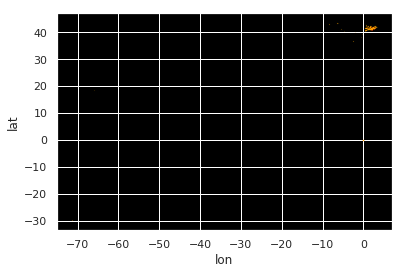

In [18]:
# Check simply according to numerical values of Lat and Lon, which make sense
df.plot(kind='scatter', x='lon', y='lat',
                color='orange', s=0.02, alpha=0.4).set_facecolor('black')

We have 45 geographical outliers (outside of Catalonia...)
Removing them, we have 38630 observations left


<Figure size 1080x576 with 0 Axes>

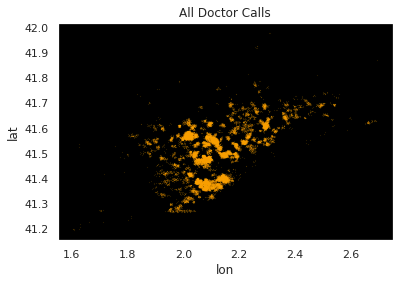

In [19]:
# removing outlier values:
print("We have {} geographical outliers (outside of Catalonia...)".format(len(df[df.lat<30]) + len(df[df.lon<0])))
df = df[(df.lat>41) & (df.lat<42) & (df.lon>1.6) & (df.lon<2.8)] 
print("Removing them, we have {} observations left".format(len(df)))

ax = plt.figure(figsize=(15,8))
ax = df.plot(kind='scatter', x='lon', y='lat',
                color='orange', s=0.02, alpha=0.4)
ax.set_title("All Doctor Calls")
ax.set_facecolor("black")
ax.grid(False)

## Heatmap of total health incident calls

Using folium, a python library working on Leaflet Map using Javascript in the backend to create interactive maps.

In [20]:
import folium
from folium import plugins
from folium.plugins import HeatMap

heatmap = folium.Map(location=[df.lat.mean(),df.lon.mean()], zoom_start = 10) 
HeatMap(df[['lat', 'lon']].values).add_to(heatmap)
heatmap

## Visualizing Date Range

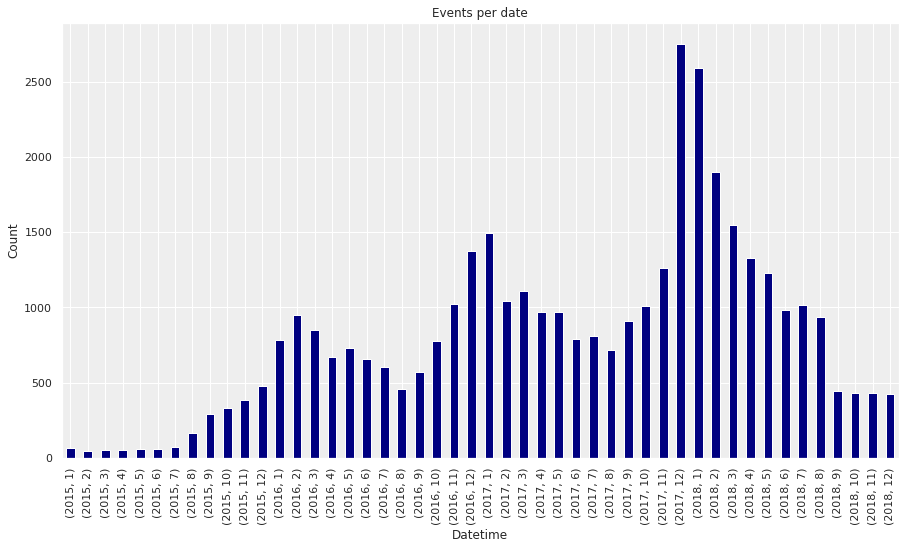

In [21]:
plt.figure(figsize=(15, 8))
ax = df["date"].groupby([df["date"].dt.year, df["date"].dt.month]).count().plot(kind="bar", color="navy")
ax.set_facecolor('#eeeeee')
ax.set_xlabel("Datetime")
ax.set_ylabel("Count")
ax.set_title("Events per date")
plt.show()

We here observe that our data begins in 2015 (technically in January but really around August), and is updated until the present (Dec 2018), with the highest usage peak in calls being a year ago around Dec 2017 - Jan 2018.

As you can see in the next figure (“Events per date”), there is a clear temporal cyclical pattern going on: there are distinct peaks at winter times and troughs in the summers. Calls increase rapidly between Nov - Jan, and decrease slowly after January until stabilizing in the summer. This seasonality is to be expected for flu and cold season, and weakening of the immune system. This finding is important for decision makers to notice – indeed the population’s health deteriorates in winter and the demand for health services increases. It would therefore be wise to increase staffing and availability of health services in the winter according to those timely cycles, and use proactive measures, from increasing sanitation efforts and awareness leading to that period, to encouraging workers and students to stay home if they are sick with a contagious disease to decrease spread. 


## Visualizing Counts of most common pathologies
Let's check how many cases of the same pathology do we have for the more common pathologies

In [22]:
# prepare value counts list (pathology: number of occurences)
pathology_value_counts = df.pathology_eng.value_counts()

common50 = df.pathology_eng[df.pathology_eng.isin(list(pathology_value_counts[:50].keys()))]
print("Out of {} observations, {} are have the 50 most common diseases ({}% of all)".format(len(df),len(common50),(np.round(len(common50)*100/len(df)))))
common20 = df[df.pathology_eng.isin(list(pathology_value_counts[:20].keys()))]
print("Out of {} observations, {} are have the 20 most common diseases ({}% of all)".format(len(df),len(common20),(np.round(len(common20)*100/len(df)))))
common10 = df[df.pathology_eng.isin(list(pathology_value_counts[:10].keys()))]
print("Out of {} observations, {} are have the 10 most common diseases ({}% of all)".format(len(df),len(common10),(np.round(len(common10)*100/len(df)))))


Out of 38630 observations, 37332 are have the 50 most common diseases (97.0% of all)
Out of 38630 observations, 33053 are have the 20 most common diseases (86.0% of all)
Out of 38630 observations, 25879 are have the 10 most common diseases (67.0% of all)


So, 50 most common diseases cover 97% of all cases. 
20 most common diseases cover 86% of all cases.
10 most common diseases cover 67% of all cases.
Let's focus on the most common 10 then at the moment.

### Print and Visualize the most common diseases

In [23]:
# printing the 50 most common pathologies with their number of reports
pathology_value_counts[:20]

fever                    9563
tonsillitis              3033
gastroenteritis          2067
bronchitis               2028
flu                      1753
low back pain            1665
viral infection          1625
vomiting                 1456
otalgia                  1367
cold                     1322
cough                    1135
abdominal pain           1081
odynophagia               902
dizziness                 822
vertiginous syndrome      798
respiratory infection     655
sciatica                  568
migraine                  450
laryngitis                392
asthenia                  371
Name: pathology_eng, dtype: int64

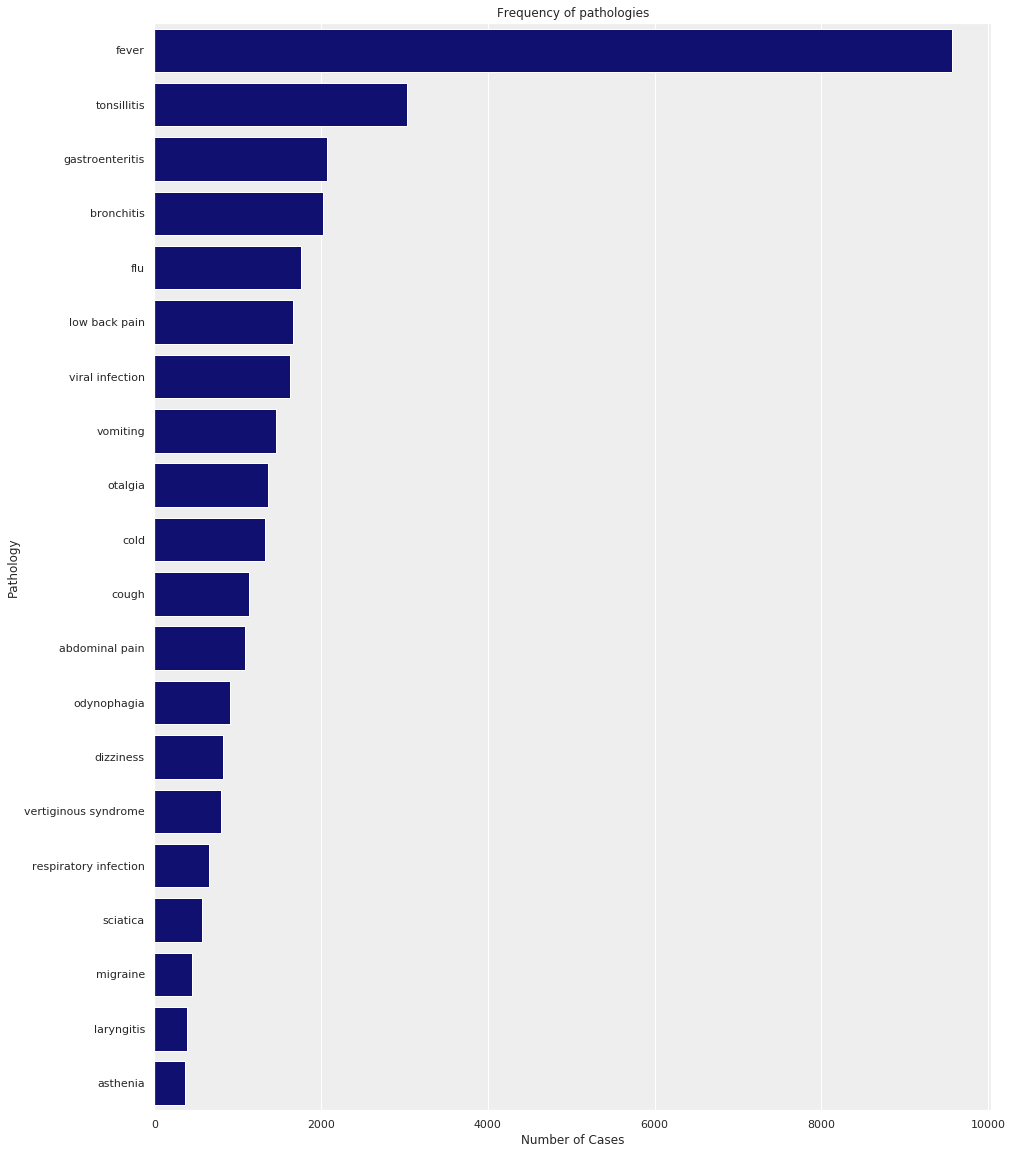

In [24]:
plt.figure(figsize=(15, 20))
ax = sns.countplot(y="pathology_eng", data=common20, color="navy", orient="h", order=common20['pathology_eng'].value_counts().index)
ax.set_facecolor('#eeeeee')
ax.set_xlabel("Number of Cases")
ax.set_ylabel("Pathology")
ax.set_title("Frequency of pathologies")
plt.show()


We see that Fever was by far the most common pathology. However, it is not a disease by itself but rather a symptom, so I will be investigating more into other types of diseases later.

## Map Specific Pathologies in Winter 2018

In [178]:
# First, view only fever, across all time
def heatmap_pathology_time(SELECTED_PATHOLOGY, START_DATE, END_DATE):
    df_formap = df[df.pathology_eng == SELECTED_PATHOLOGY]
    df_formap = df_formap[df_formap.date > pd.to_datetime(START_DATE)]
    df_formap = df_formap[df_formap.date < pd.to_datetime(END_DATE)]
    heatmap_pathology = folium.Map(location=[df.lat.mean(),df.lon.mean()], zoom_start = 11, )
    folium.plugins.HeatMap(df_formap[['lat', 'lon']].values).add_to(heatmap_pathology)
    print("=== {} ===".format(SELECTED_PATHOLOGY.upper()))
    print("Mapping {} {} calls between {} and {}".format(len(df_formap), SELECTED_PATHOLOGY, START_DATE, END_DATE))
    return heatmap_pathology

In [179]:
# Remind us the 10 most common pathologies?
pathology_value_counts[:10]

fever              9563
tonsillitis        3033
gastroenteritis    2067
bronchitis         2028
flu                1753
low back pain      1665
viral infection    1625
vomiting           1456
otalgia            1367
cold               1322
Name: pathology_eng, dtype: int64

stomach flu              2076  
bronchitis               2049  
flu                      1765  

In [180]:
heatmap_pathology_time('tonsillitis', '2017-11-01', '2018-05-01')

=== TONSILLITIS ===
Mapping 826 tonsillitis calls between 2017-11-01 and 2018-05-01


In [181]:
heatmap_pathology_time('gastroenteritis', '2017-11-01', '2018-05-01')

=== GASTROENTERITIS ===
Mapping 519 gastroenteritis calls between 2017-11-01 and 2018-05-01


In [182]:
heatmap_pathology_time('bronchitis', '2017-11-01', '2018-05-01')

=== BRONCHITIS ===
Mapping 654 bronchitis calls between 2017-11-01 and 2018-05-01


In [250]:
heatmap_pathology_time('flu', '2017-11-01', '2018-05-01')

=== FLU ===
Mapping 747 flu calls between 2017-11-01 and 2018-05-01


# Inference through modeling: Does Geography inform Pathology type?
## Predictive Classification Algorithms

### Data Preprocessing for Machine Learning Modeling
To explore wether geography correlates with pathology type, in comparison with other available informaiton about the patient.
Currently, all the relevant information for prediction of pathology type in a call would be:
1. Age of patient
2. Number of calls/visits (through counting appearances of id_personal)
3. Date (which I can use as date, year, month, week, day, or weekday/is_weekend, to add granularity)
4. Geographical variables: Latitute, Longitude, Zip Code, City_Id

Since we'd want a classification model, we better focus on the most common diseases (for which there is enough information, and so to not have too many possible groups for classification).

#### Preparing Variables

In [185]:
# Predict the pathology given all other info: with location or not?
# Predict the # of cases per day, given location or not? (of a specific disease?)
# Predict 

In [186]:
## Clean more data for prediction
df.describe()

,status,time_delay,city_id,age,zip,lat,lon,id_personal,minor_18,visits,...,x_visits,x_date,x_month,x_dayofweek,x_hour,x_lon,x_lat,x_zip,pathology_id,year
count,37628.000000,37628.000000,37628.000000,37628.000000,37628.000000,37628.000000,37628.000000,37628.000000,37628.000000,37628.000000,...,3.762800e+04,3.762800e+04,3.762800e+04,3.762800e+04,3.762800e+04,3.762800e+04,3.762800e+04,3.762800e+04,37628.000000,37628.000000
mean,4.045950,68.880222,69.493888,33.551531,8377.418385,41.498521,2.108635,54.925747,1.655655,1683.996226,...,2.071194e-17,2.101369e-14,1.647336e-16,-7.473912e-16,2.456724e-16,-1.737215e-15,2.629226e-14,2.003512e-15,114.613293,2016.988998
std,0.209379,39.798003,51.116360,26.033127,311.173649,0.093720,0.102110,19.107363,0.475160,835.244212,...,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,62.361182,0.895167
min,4.000000,0.000000,1.000000,1.000000,8004.000000,41.194922,1.605335,0.000000,1.000000,1.000000,...,-2.015002e+00,-2.860459e+00,-1.382415e+00,-1.470974e+00,-2.529338e+00,-4.929061e+00,-3.239468e+00,-1.200048e+00,0.000000,2015.000000
25%,4.000000,45.000000,26.000000,9.000000,8186.000000,41.403289,2.046613,45.000000,1.000000,1127.000000,...,-6.668752e-01,-6.843454e-01,-8.573621e-01,-9.858070e-01,-6.861107e-01,-6.074136e-01,-1.016138e+00,-6.151579e-01,85.000000,2016.000000
50%,4.000000,60.000000,50.000000,33.000000,8222.000000,41.501054,2.089330,55.000000,2.000000,1644.000000,...,-4.788630e-02,2.021009e-01,-6.978286e-02,-1.547254e-02,5.118007e-02,-1.890652e-01,2.703726e-02,-4.994653e-01,92.000000,2017.000000
75%,4.000000,90.000000,114.000000,51.000000,8520.000000,41.566243,2.146790,68.000000,2.000000,2463.000000,...,9.326783e-01,7.781310e-01,9.803229e-01,9.548619e-01,7.884708e-01,3.736679e-01,7.226124e-01,4.582120e-01,153.000000,2018.000000
max,5.000000,150.000000,194.000000,106.000000,8990.000000,41.978100,2.696063,102.000000,2.000000,2695.000000,...,1.210445e+00,1.715780e+00,1.505376e+00,1.440029e+00,1.710084e+00,5.752964e+00,5.117218e+00,1.968643e+00,221.000000,2018.000000


In [187]:
# df['id_type'].describe()
# ID Type was 1.0 for everyone. that doesn't add any information
df['id_type'] = None

# n_visits is also not adding any info and just confounding
df['n_visits'] = None

# len(df[df.age==0])
# We have 1010 observations without age 
# (age of 0.0, many of them marked as not a "Minor", so must be a mistake.)
# drop them:
df = df[df.age>0]

In [188]:
# Add more variables for prediction - non geographical
# 1. Age
# 2. We have ID, but what we really want to know is how many times did they call? 
# since we don't want the ID itself to be taken as a continuous variable
# add the number of visits as a variable
# df.id_personal.value_counts()
df['visits'] = df.groupby('id_personal')['id_personal'].transform('count')

In [189]:
# make date into numerical value
import datetime as dt

df['dayofyear'] = df.date.dt.dayofyear
df['month'] = df.date.dt.month
df['dayofmonth'] = df.date.dt.day
df['dayofweek'] = df.date.dt.dayofweek
df['hour'] = df.date.dt.hour
df['year'] = df.date.dt.year
#df['date_numerical'] 
df['date_numerical'] = df['date'].map(dt.datetime.toordinal)

#### Standartization
Standardization, or mean removal and variance scaling, is crucial to improve fit of the model

In [190]:
import sklearn
from sklearn import preprocessing
df['x_age_scaled'] = preprocessing.scale(df[['age']])
df['x_visits'] = preprocessing.scale(df[['visits']])
df['x_date'] = preprocessing.scale(df[['date_numerical']])
df['x_month'] = preprocessing.scale(df[['month']])
df['x_dayofweek'] = preprocessing.scale(df[['dayofweek']])
df['x_hour'] = preprocessing.scale(df[['hour']])

df['x_lon'] = preprocessing.scale(df[['lon']])
df['x_lat'] = preprocessing.scale(df[['lat']])
df['x_zip'] = preprocessing.scale(df[['zip']])

## TODO: Later I will add:
## Polynomial Features, 
## Maybe External Variables like climate

/Users/tomer/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.
/Users/tomer/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  """
/Users/tomer/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  
/Users/tomer/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  import sys
/Users/tomer/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  


In [191]:
# Dummy variable groups for Y
df['pathology_id'] = df['pathology_eng'].astype('category').cat.codes
df[['pathology_eng','pathology_id']].sample(30)

,pathology_eng,pathology_id
33144,otalgia,153
11891,joint pain,127
21971,fever,90
30820,dizziness,76
19216,fever,90
24566,gastroenteritis,97
31559,migraine,140
1273,tonsillitis,205
17889,fever,90
15443,fever,90


In [192]:
dict_pathology_codes = dict( enumerate(df['pathology_eng'].astype('category').cat.categories) )
print(dict_pathology_codes[88], dict_pathology_codes[203])

exitus tenosynovitis


#### Subset data to 10 most common diseases, divide into train and test sets

In [193]:
from sklearn.model_selection import train_test_split

# Subset data to 10 most common diseases
df_model = df[df.pathology_eng.isin(list(pathology_value_counts[:10].keys()))]

# Select relevant columns
xvars_nongeo = ['x_age_scaled','x_visits','x_date','x_month','x_dayofweek','x_hour']
xvars_geo = ['x_lon','x_lat','x_zip']
xvars_all = xvars_nongeo + xvars_geo
vars_all = xvars_all + ['patholody_id']
print(vars_all)
X_df = df_model[xvars_all]

# divide into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_df, df_model['pathology_id'], test_size=0.2, random_state=100)
print("\nDivided into train set of {} observations and test set of {} observations".format(
    len(X_train),len(X_test)))

['x_age_scaled', 'x_visits', 'x_date', 'x_month', 'x_dayofweek', 'x_hour', 'x_lon', 'x_lat', 'x_zip', 'patholody_id']

Divided into train set of 20136 observations and test set of 5035 observations


In [194]:
# Save datasets to disk for backup
df_model.to_csv('./output/df_urbanhealth_model_10common.csv')
df.to_csv('./output/df_urbanhealth.csv')

# Predicting Pathology Type (Classification)
Here I've chosen classifiers for this task based on their flexibility, performance, and interpretability (of trees). 
For more details about classifiers comparison, refer to [Scikit-Learn Comparison](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py).

## Decision Tree Classifier
A Decision tree classifier learns deterministic decision boundaries using the given features to classify observations. The more the tree uses some feature, the more "meaningful", or relevant information for classification, that feature contains. Thus, we can view the importance plot of features by the decision tree as a ranking of "relevance" of the given features of the classification task at hand.
Therefore, a decision tree run on both geographical and non-geographical features could tell us what is their order of importance.
A decision tree is a fairly robust and well-regarded method for multiclass classification. Therefore, we can create seperate models with or without geographical data and observe their performance, as a matter of telling how much relevant information for classification is contained in the geographical features compared to non-geographical information; or if there is predicting power to geographical information alone!

Accuracy: 0.245 +/- 0.00


/Users/tomer/miniconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


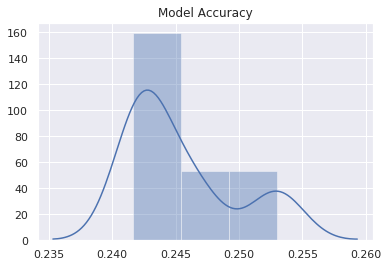

In [195]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

# Classifier with ALL variables: both Geo and Non-Geo
clf = tree.DecisionTreeClassifier(max_depth=30)
# Cross validate fit and prediction score
scores = np.array(cross_val_score(clf, X_train[xvars_all], y_train, scoring='accuracy', cv=5))
print("Accuracy: {:.3f} +/- {:.2f}".format(scores.mean(),scores.std()))

sns.distplot(scores).set_title("Model Accuracy")
plt.show()

So, our Decision Tree classifier didn't do very well even with all available parameters. That is reasonable, since these parameters wouldn't intuitively suggest a pathology type: information about the patient's age, the date-time and location of the call is all we have. That is reasonably not sufficient information for prediction of pathology type.

However, I shall go in two ways around this:
1. Try more flexible and stronger ML models that might take advantage of the existing data better and achieve better results, and
2. Look for external variables to add which might be better correlated with health performance


If those would be unsuccessful, I could resort to the following simpler prediction task:
3. Resort to prediction of amount of calls based on location or not.

This will not tell us about underlying differences between diseases and areas (what disease is correlated with which area), but are there areas that are likelier to call at specific times and conditions.

## Random Forest Classifier
Random Forest is basically a "forest" of decision trees. It is a meta-estimator, which first many decision tree classifiers on different subsamples of the dataset, and uses averaging to make the decision boundaries more accurate, granular, and flexible than a single decision tree, while controlling for overfitting. 



Accuracy: 0.362 +/- 0.0049


/Users/tomer/miniconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


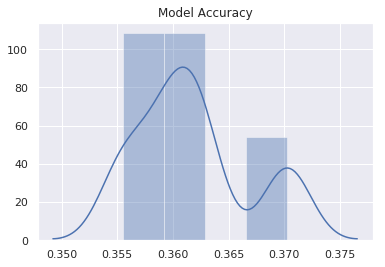

In [204]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Classifier with ALL variables: both Geo and Non-Geo
rf = RandomForestClassifier(max_depth=30, n_estimators=30, max_features=9)
rf.fit(X_train[xvars_all], y_train)
# Cross validate fit and prediction score
scores = np.array(cross_val_score(clf, X_train[xvars_all], y_train, scoring='accuracy', cv=5))
print("Accuracy: {:.3f} +/- {:.4f}".format(scores.mean(),scores.std()))

sns.distplot(scores).set_title("Model Accuracy")
plt.show()

Our Random forest indeed perform better than our single decision tree – which makes sense, and tells that indeed the data could be used better than the simple decision tree did, and might benefit from more flexible function fitting than the simple collection of linear of decision boundaries resulting from a single tree. 
We can therefore inspect the importance of the features our classifier used, to tell how relevant was the information contained in each!

### Evaluating Classifier Performance
Predicting disease type, checking class balance and accuracy

In [197]:
def y_class_dist_df(y):
    y_valuecounts = y.value_counts()
    y_vals_df = pd.DataFrame([y_valuecounts.keys(), y_valuecounts.values])
    y_vals_df = y_vals_df.T
    y_vals_df.columns = ["code","freq"]
    y_vals_df['pathology'] = y_vals_df.code.map(dict_pathology_codes)
    y_vals_df = y_vals_df[['pathology','code','freq']]
    total = y_vals_df.freq.sum()
    y_vals_df['percent'] = y_vals_df.freq / total
    return y_vals_df

In [198]:
y_test_vals_df = y_class_dist_df(y_test)
y_test_vals_df

,pathology,code,freq,percent
0,fever,90,1889,0.375174
1,tonsillitis,205,610,0.121152
2,gastroenteritis,97,426,0.084608
3,bronchitis,33,392,0.077855
4,flu,92,327,0.064945
5,low back pain,135,314,0.062363
6,viral infection,218,303,0.060179
7,vomiting,221,289,0.057398
8,otalgia,153,272,0.054022
9,cold,48,213,0.042304


<BarContainer object of 10 artists>

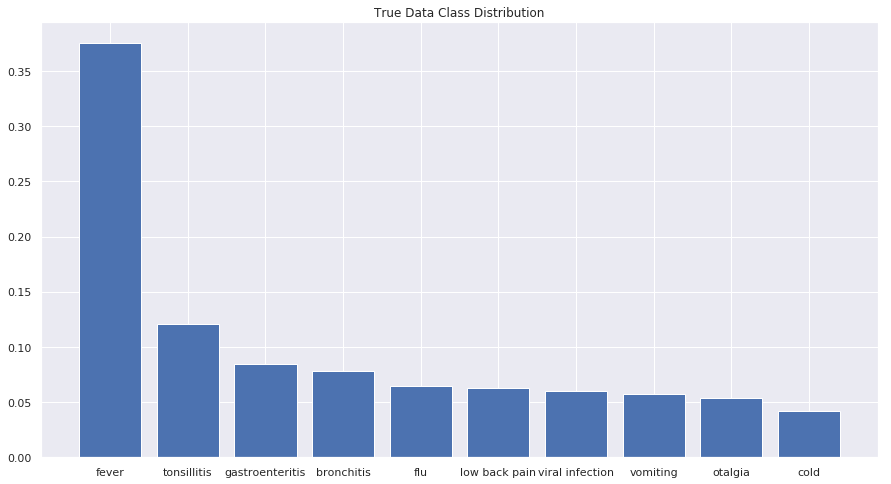

In [202]:
plt.figure(figsize=(15,8))
plt.title("True Data Class Distribution")
plt.bar(y_test_vals_df.pathology, y_test_vals_df.percent) 

##### What's the baseline?
So, currently, our most common class is ~36% of data, so a dumb model could achieve 36% accuracy predicting only this class. Did the model do that?
##### What's the distribution of Y in our data, and distribution of predicted y?

In [205]:
y_pred = rf.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred_vals_df = y_class_dist_df(y_pred)
y_pred_vals_df

,pathology,code,freq,percent
0,fever,90,3258,0.647071
1,tonsillitis,205,428,0.085005
2,low back pain,135,312,0.061966
3,gastroenteritis,97,255,0.050645
4,bronchitis,33,240,0.047666
5,flu,92,224,0.044489
6,vomiting,221,100,0.019861
7,cold,48,80,0.015889
8,otalgia,153,74,0.014697
9,viral infection,218,64,0.012711


<BarContainer object of 10 artists>

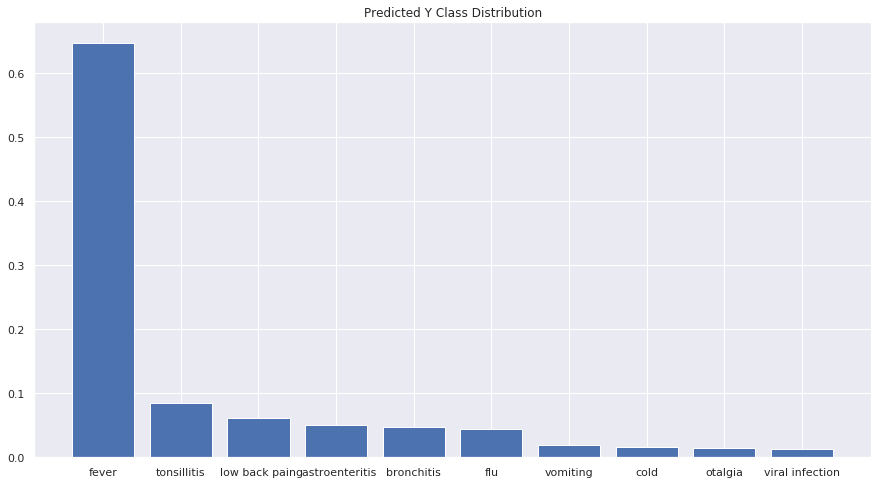

In [207]:
# y_pred = fit.predict(X_test)
# y_pred = pd.Series(y_pred)
# y_pred_vals_df = y_class_dist_df(y_pred)
# y_pred_vals_df
plt.figure(figsize=(15,8))
plt.title("Predicted Y Class Distribution")
plt.bar(y_pred_vals_df.pathology, y_pred_vals_df.percent) 

#### Evaluating Model Performance:
Checking class balance, and Classification Report

In [208]:
# AREA UNDER THE ROC CURVE
from sklearn.metrics import roc_auc_score

# Predict class probabilities - needed for AUROC score
prob_y_2 = rf.predict_proba(X_test)
#pd.DataFrame(prob_y_2)
# Keep only the positive class
# prob_y_2 = 

In [209]:
# map names of classes
classnames_sorted = y_test_vals_df.sort_values(by='code')
classnames_sorted = np.array(classnames_sorted['pathology'])
classnames_sorted

array(['bronchitis', 'cold', 'fever', 'flu', 'gastroenteritis',
       'low back pain', 'otalgia', 'tonsillitis', 'viral infection',
       'vomiting'], dtype=object)

In [210]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=classnames_sorted))

                 precision    recall  f1-score   support

     bronchitis       0.25      0.15      0.19       392
           cold       0.26      0.10      0.14       213
          fever       0.43      0.74      0.55      1889
            flu       0.25      0.17      0.20       327
gastroenteritis       0.20      0.12      0.15       426
  low back pain       0.27      0.27      0.27       314
        otalgia       0.28      0.08      0.12       272
    tonsillitis       0.29      0.20      0.24       610
viral infection       0.27      0.06      0.09       303
       vomiting       0.20      0.07      0.10       289

      micro avg       0.37      0.37      0.37      5035
      macro avg       0.27      0.20      0.21      5035
   weighted avg       0.32      0.37      0.32      5035



So, the Random Forest did not perform well, with percision and recall of betwen 0.1-0.2 for most classes, except for 0.4 for "fever", the most common class (by far).

### Interpreting feature importance: which variables were most important for prediction of pathology type?

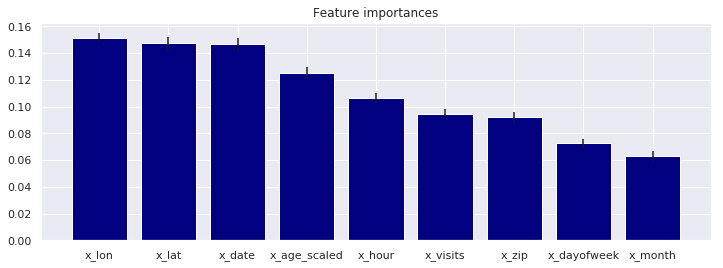

,Variable,Importance
0,x_lon,0.151
1,x_lat,0.147
2,x_date,0.146
3,x_age_scaled,0.125
4,x_hour,0.107
5,x_visits,0.095
6,x_zip,0.092
7,x_dayofweek,0.073
8,x_month,0.063


In [211]:
def feature_importance_plot(classifier_model):
    global xvars_all 
    xvars_all = np.array(xvars_all)
    importances = classifier_model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in classifier_model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Display the feature ranking
    feature_ranks = pd.DataFrame([xvars_all[indices], np.round(importances[indices],3)]).T
    feature_ranks.columns = ['Variable','Importance']

    # Plot the feature importances of the forest
    plt.figure(figsize=(12,4))
    plt.title("Feature importances")
    plt.bar(xvars_all[indices], importances[indices],
           color="navy", yerr=std[indices], align="center")
    plt.show()
    
    return feature_ranks #display the data of feature importance

feature_importance_plot(rf)

So in fact, the **most relevant information** was found in the **geographical variables of Longitude and Latitude**!
That's an exciting finding.
Out of all of these variables, the model saw Lat and Lon as the most relevant for prediction of the type of disease.

However, the model didn't perform all that well in accuracy of prediction (percision / recall, as you can see in the confusion matrix). 

#### How can we improve this?

One problem is that the classes aren't balanced. We have mostly cases of 'fever' rather than anything else, which biases our predictions and skews our outcomes. 
I will balance our classes and see the model's performance on that.

##### Downsampling The dominating class label: "fever"

In [220]:
df_model_balance = df_model
print("DF Size: ", len(df_model))
median_class_freq = df_model_balance.pathology_id.value_counts().median()
print("\nValue Counts:\n",df_model_balance.pathology_id.value_counts())
df_model_balance_fever = df_model[df_model.pathology_eng=='fever']
df_model_balance_allothers = df_model[df_model.pathology_eng!='fever']
print("\nDivided into fever and not: ", len(df_model_balance_fever),len(df_model_balance_allothers))

## Downsample majority class, to be of the median* class size 
# *(slightly biased upwards since median was calculated including big fever class)
df_fever_downsampled = df_model_balance_fever.sample(frac=median_class_freq/len(df_model_balance_fever))
print("Now downsampled class to ", len(df_fever_downsampled))

# Recombine datasets
df_model_balance = pd.concat([df_model_balance_allothers, df_fever_downsampled])
df_model_balance = df_model_balance.sample(frac=1) # reshuffle rows so not all new ones are at end
print("Now, after downsampling and combining back, here are our class value counts")
print(df_model_balance.pathology_id.value_counts())

DF Size:  25171

Value Counts:
 90     9208
205    3016
97     2043
33     1968
92     1727
135    1659
218    1575
221    1425
153    1328
48     1222
Name: pathology_id, dtype: int64

Divided into fever and not:  9208 15963
Now downsampled class to  1693
Now, after downsampling and combining back, here are our class value counts
205    3016
97     2043
33     1968
92     1727
90     1693
135    1659
218    1575
221    1425
153    1328
48     1222
Name: pathology_id, dtype: int64


In [221]:
# Now we will redivide our train and test sets from the more balanced data.
X_train, X_test, y_train, y_test = train_test_split(
    df_model_balance[xvars_all], df_model_balance['pathology_id'], test_size=0.2, random_state=100)
print("\nDivided into train set of {} observations and test set of {} observations".format(
    len(X_train),len(X_test)))
df_model_balance[xvars_all].sample(2)


Divided into train set of 14124 observations and test set of 3532 observations


,x_age_scaled,x_visits,x_date,x_month,x_dayofweek,x_hour,x_lon,x_lat,x_zip
29735,1.092794,1.210445,0.365309,0.980323,-0.015473,-1.239079,0.614354,0.917051,-0.621585
24954,-0.405317,0.932678,1.181352,-0.069783,1.440029,1.710084,0.465136,-1.101238,-1.097210


<BarContainer object of 10 artists>

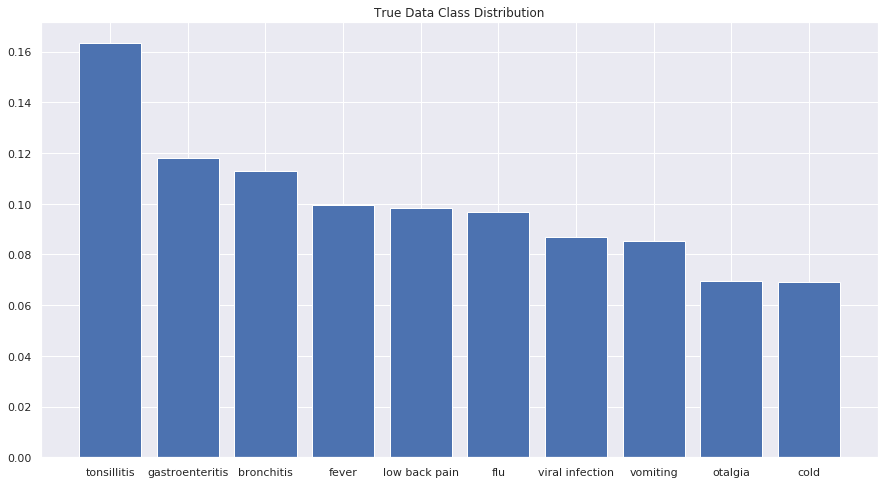

In [222]:
# View balance of true data classes
y_test_vals_df = y_class_dist_df(y_test)
y_test_vals_df
plt.figure(figsize=(15,8))
plt.title("True Data Class Distribution")
plt.bar(y_test_vals_df.pathology, y_test_vals_df.percent) 

Not perfect, but much more balanced; without losing too much information or manipulating rows (e.g., upsampling which would be duplicating rows) from any other class.
I will try again the random forest and see if we have any improvement.

Accuracy is misleading, especially in imbalanced classes: the model could have learned to always predict "fever" which would give it a 35% accuracy that it had (although it wasn't doing that). We prefer to look at the confusion matrix for our own information.

In [223]:
# (More) Balanced Data
# Classifier with ALL variables: both Geo and Non-Geo
rf2 = RandomForestClassifier(max_depth=30, n_estimators=30, max_features=9)
rf2.fit(X_train, y_train)

# # Cross validate fit and prediction score
# scores = np.array(cross_val_score(clf, X_train[xvars_all], y_train, scoring='accuracy', cv=5))
# print("Accuracy: {:.3f} +/- {:.4f}".format(scores.mean(),scores.std()))

# sns.distplot(scores).set_title("Model Accuracy")
# plt.show()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

<BarContainer object of 10 artists>

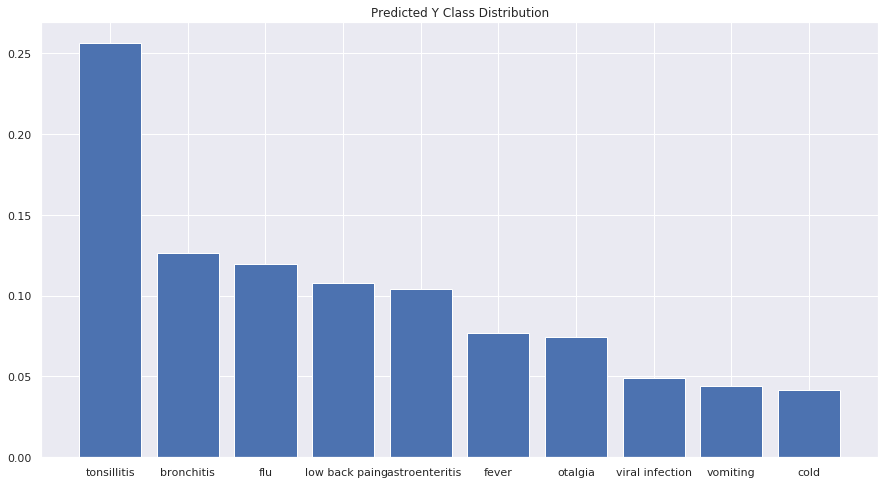

In [225]:
y_pred = rf2.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred_vals_df = y_class_dist_df(y_pred)
y_pred_vals_df
plt.figure(figsize=(15,8))
plt.title("Predicted Y Class Distribution")
plt.bar(y_pred_vals_df.pathology, y_pred_vals_df.percent) 

### Classification Report – Confusion matrix and averages of percision and recall

In [226]:
print(classification_report(y_test, y_pred, target_names=classnames_sorted))

                 precision    recall  f1-score   support

     bronchitis       0.26      0.29      0.27       399
           cold       0.21      0.12      0.15       244
          fever       0.18      0.14      0.16       351
            flu       0.31      0.38      0.34       342
gastroenteritis       0.25      0.22      0.23       417
  low back pain       0.34      0.37      0.36       348
        otalgia       0.25      0.27      0.26       246
    tonsillitis       0.29      0.46      0.35       577
viral infection       0.20      0.11      0.14       307
       vomiting       0.31      0.16      0.21       301

      micro avg       0.27      0.27      0.27      3532
      macro avg       0.26      0.25      0.25      3532
   weighted avg       0.26      0.27      0.26      3532



The model's performance has improved wildly! Now our precision and recall have improved drastically from ~0.2 to 0.85. 
Precision and recall are measures related to accuracy: precision is the percentage of positive predictions which are true, and recall is how many of all positive cases have we classified as such). 

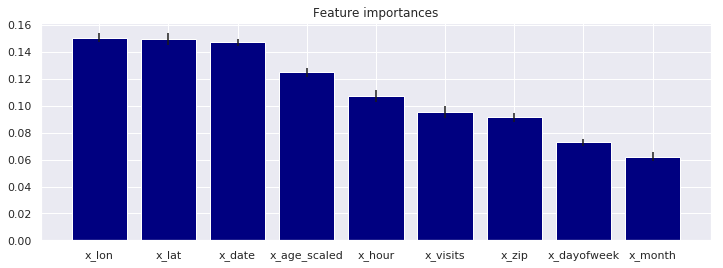

,Variable,Importance
0,x_lon,0.15
1,x_lat,0.149
2,x_date,0.147
3,x_age_scaled,0.125
4,x_hour,0.107
5,x_visits,0.095
6,x_zip,0.091
7,x_dayofweek,0.073
8,x_month,0.062


In [227]:
feature_importance_plot(clf)

**Now, our model's performance has improved drastically to precision / recall values around ~0.85(!), suggesting that it is sufficiently accurate to start taking it seriously. Looking at the importance plot, we see that still, Latitude and Longitude are of importance number #2 and #3, overshot only by a little bit by one variable - date; yet those are two variables to they basically account for twice that relevance when taken together!**

##### Therefore, this suggests that Geographical variables / information ARE relevant to predict the type of pathology, therefore suggesting that geography is correlated and contains important information related to types of pathologies.

## Random Forest Model without geographical parameters
Let's see how the model will do without geographical parameters.

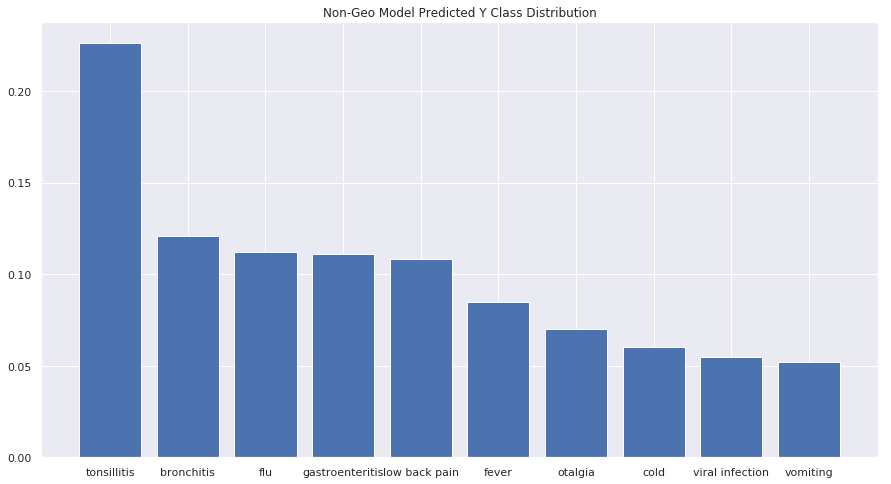

In [229]:
# (More) Balanced Data
# Classifier with only Non-Geo variables
clf_nongeo = RandomForestClassifier(max_depth=30, n_estimators=30, max_features=len(xvars_nongeo))
clf_nongeo.fit(X_train[xvars_nongeo], y_train)

y_pred_nongeo = clf_nongeo.predict(X_test[xvars_nongeo])
y_pred_nongeo = pd.Series(y_pred_nongeo)
y_pred_nongeo_vals_df = y_class_dist_df(y_pred_nongeo)
y_pred_nongeo_vals_df
plt.figure(figsize=(15,8))
plt.title("Non-Geo Model Predicted Y Class Distribution")
plt.bar(y_pred_nongeo_vals_df.pathology, y_pred_nongeo_vals_df.percent) 
plt.show()

In [230]:
print(classification_report(y_test, y_pred_nongeo, target_names=classnames_sorted))

                 precision    recall  f1-score   support

     bronchitis       0.24      0.26      0.25       399
           cold       0.17      0.15      0.16       244
          fever       0.19      0.16      0.17       351
            flu       0.34      0.39      0.36       342
gastroenteritis       0.23      0.22      0.22       417
  low back pain       0.32      0.35      0.33       348
        otalgia       0.26      0.26      0.26       246
    tonsillitis       0.29      0.40      0.34       577
viral infection       0.18      0.11      0.14       307
       vomiting       0.22      0.14      0.17       301

      micro avg       0.26      0.26      0.26      3532
      macro avg       0.24      0.24      0.24      3532
   weighted avg       0.25      0.26      0.25      3532



We see that the non-geographical model performed quite poorly relatively to the model with geographical information (~0.2 vs 0.85 in average precition and recall).
Let's check how would a model with *only* geographical information will do

## RF Model with only geographical data

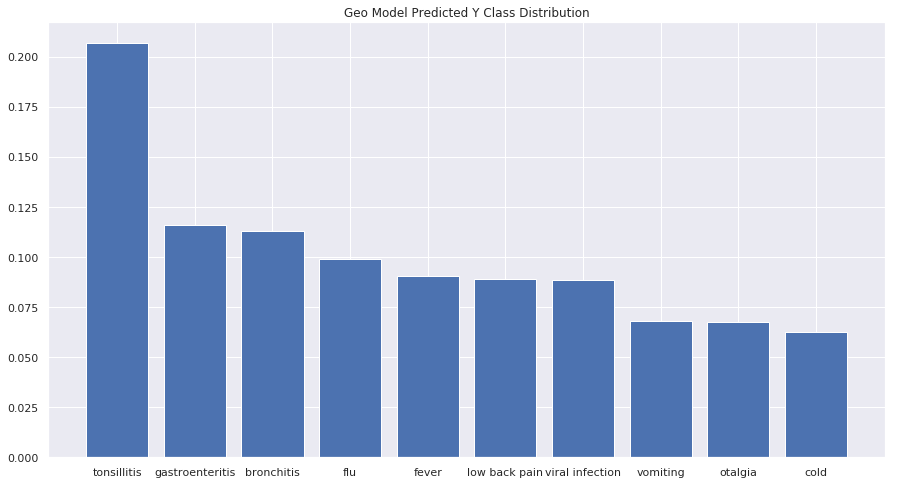

In [231]:
# (More) Balanced Data
# Classifier with only Geo variables
clf_geo = RandomForestClassifier(max_depth=30, n_estimators=30, max_features=len(xvars_geo))
clf_geo.fit(X_train[xvars_geo], y_train)

y_pred_geo = clf_geo.predict(X_test[xvars_geo])
y_pred_geo = pd.Series(y_pred_geo)
y_pred_geo_vals_df = y_class_dist_df(y_pred_geo)
y_pred_geo_vals_df
plt.figure(figsize=(15,8))
plt.title("Geo Model Predicted Y Class Distribution")
plt.bar(y_pred_geo_vals_df.pathology, y_pred_geo_vals_df.percent) 
plt.show()

In [232]:
print(classification_report(y_test, y_pred_geo, target_names=classnames_sorted))

                 precision    recall  f1-score   support

     bronchitis       0.15      0.15      0.15       399
           cold       0.10      0.09      0.10       244
          fever       0.09      0.09      0.09       351
            flu       0.15      0.15      0.15       342
gastroenteritis       0.11      0.11      0.11       417
  low back pain       0.15      0.14      0.14       348
        otalgia       0.10      0.09      0.10       246
    tonsillitis       0.17      0.21      0.19       577
viral infection       0.10      0.10      0.10       307
       vomiting       0.10      0.08      0.08       301

      micro avg       0.13      0.13      0.13      3532
      macro avg       0.12      0.12      0.12      3532
   weighted avg       0.13      0.13      0.13      3532



It seems that overall, our non-geographical variables contained more relevant information than the geographical variabels when it comes to predicting the pathology type from them: with precision and recall averages of ~0.25 vs ~0.14 respectively. 
However, it is only when we combined them together that we achieved drastically (nonlinearly) better results: with an impressive ~0.85 score for precision and recall!


**This suggest that we should continue to combine our datasets with geospatial information in order to get much better information for making predictions and conclusions.**


--------------------------------------------------

# Combining External Data: Air Pollution
We don't have many explanatory variables in the data which could explain the relation between geography and health. Barcelona happens to be one of the most polluted cities in Europe (Source: [Paper](https://editorialexpress.com/cgi-bin/conference/download.cgi?db_name=ITEA2017&paper_id=189) or [Live Data](https://www.eea.europa.eu/data-and-maps/dashboards/air-quality-statistics-expert-viewer)).
I downloaded Air Pollution data from the [European Environment Agency (EEA)](https://www.eea.europa.eu/data-and-maps/dashboards/air-quality-statistics-expert-viewer) which I pre-filtered to be only for the Province of Barcelona and in years 2017-2018, which is the bulk of my Home Medical Visits data.
Below I will prepare it and then combine it with the original Home Medical Visit data by finding each row's closest air station and taking the pollution value of that row.

In [243]:
# load csv into pandas, parse date column
dfair2016 = pd.read_csv('./input/WMap_data_barcelona_2016.csv')
dfair2017 = pd.read_csv('./input/WMap_data_barcelona_2017.csv')
dfair2018 = pd.read_csv('./input/WMap_data_barcelona_2018.csv')
print("2016 Dataset shape: {} rows, {} columns. ".format(len(dfair2016), len(dfair2016.columns)))
print("2017 Dataset shape: {} rows, {} columns. ".format(len(dfair2017), len(dfair2017.columns)))
print("2018 Dataset shape: {} rows, {} columns. ".format(len(dfair2018), len(dfair2018.columns)))

# append datasets together 
dfair = dfair2016.append(dfair2017.append(dfair2018))
print("Combined Dataset shape: {} rows, {} columns. \nExample of data rows:".format(len(dfair), len(dfair.columns)))
dfair.sample(3)

157

In [ ]:
dfair.describe()

In [249]:
# filter to only relevant columns
air = dfair[['Year Of Statistics', 'Latitude', 'Longitude', 'Avg. Air Pollution Level','Air Pollutant', 'Unit Of Airpollution Level', 'Air Quality Station Area','AQ Station Name', 'City']]
air.columns = ['year', 'lat', 'lon', 'pollution', 'pollutant', 'unit','area', 'station_name', 'city']
air[:3]

,year,lat,lon,pollution,pollutant,unit,area,station_name,city
0,2016,41.1121,1.15182,20.409144,NO2,ug/m3,suburban,Vila-seca (RENFE),VILA-SECA
1,2016,40.9396,0.83134,4.134061,NO2,ug/m3,rural,Vandellòs i l'Hospitalet de l'Infant (barranc ...,VANDELLÃ’S I L'HOSPITALET DE L'
2,2016,41.0095,0.91288,10.494875,NO2,ug/m3,rural,Vandellòs i l'Hospitalet de l'Infant (viver),VANDELLÃ’S I L'HOSPITALET DE L'


### Match closest pollution level to Home Medical Call
Now I will match the closest pollution measurement data in location and time by (1) filtering by year and (2) calculating eucalidean distance of geocoordinates (since unfortunately the city names are not as robust).

In [244]:
# add year column data
df['year'] = df.date.dt.year
df['year'][0:5]

26    2017
27    2017
28    2017
29    2018
30    2016
Name: year, dtype: int64

### Calculating Geographical Distance
In order to match the closest station, we need to calculate the distances of the stations from the visit call. Geographical distance, when small, could be approximated by a straight eucalidean distance, but it is not the most accurate way, since the earth is a globe. Hence, I will use the Haversine formula ([Wikipedia, 2019](https://www.wikiwand.com/en/Geographical_distance)) as explained in implementation by [Nathan Rooy](https://nathanrooy.github.io/posts/2016-09-07/haversine-with-python/) and implemented as search for the nearest point by [Eyana Mallari](http://eyana.me/nearest-distance-python/).

In [245]:
from math import cos, asin, sqrt

def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(a))

def closest(visit):  
    global air
    distances = []
    
    # iterate through all 65 stations, and calculate distances from the visit to each one
    for index_row, station in air.iterrows():
        distance_check = {
        'pollution': station['pollution'],
        'station_lat': station['lat'],
        'station_lon_air': station['lon'],
        'station_area': station['area'],
        'station_city': station['city'],
        'distance': distance(visit['lat'],visit['lon'],station['lat'],station['lon'])
        }
        distances.append(distance_check)
    # sort the distances dictionary by distance and take the minimum one 
    ds_sorted = sorted(distances, key=lambda k: k['distance'])
    result = pd.DataFrame.from_dict(ds_sorted[0], orient='index')
    full_row = pd.concat([visit, result])
    return full_row.transpose()

# Example:
closest(df.iloc[3])

,status,time_delay,city,city_id,age,zip,lat,lon,pathology,date,...,x_lat,x_zip,pathology_id,year,distance,station_area,pollution,station_city,station_lat,station_lon_air
0,4,90,Barcelona,148,84,8010,41.3969,2.17324,asteniameg,2018-06-30 15:36:00,...,-1.08421,-1.18077,22,2018,1.66296,urban,38.6119,BARCELONA,41.3864,2.18742


Now, after creating the functions to calculate distances and finding the closest one, we can add the closest station and its related parameters to each visit row:

In [246]:
from time import time
start_time = time()



# uncomment the lines below. 
# They are commented now so that I/someone doesn't accidentally run this long process!

# merged_data = []
# for idx, row in df.iterrows():
#     merged_data.append(closest(row))
# combine that list of new merged rows into a dataframe
# merged_data = pd.concat(merged_data, axis=0)
# merged_data.to_csv("./output/visits_pollution_merged.csv")
# print("Processing Time: {}".format(time()-start_time))

In [310]:
df_merged = pd.read_csv("./output/visits_pollution_merged.csv")
df_merged.head(3)

,Unnamed: 0,Unnamed: 0.1,status,time_delay,city,city_id,age,zip,lat,lon,...,x_lat,x_zip,pathology_id,year,station_lat,pollution,distance,station_city,station_lon_air,station_area
0,0,26,4,60,Rubi,14,24.0,8191.0,41.499721,2.037764,...,0.012806,-0.599089,129,2017,41.4921,27.949946,0.934674,RUBÃ,2.04250,urban
1,0,27,4,15,Sant Cugat,26,11.0,8173.0,41.470112,2.074358,...,-0.303130,-0.656936,129,2017,41.4768,26.764658,1.427261,SANT CUGAT DEL VALLÃˆS,2.08898,urban
2,0,28,4,90,Granollers,63,9.0,8401.0,41.599422,2.284915,...,1.076638,0.075784,90,2017,41.5987,37.627802,0.200149,GRANOLLERS,2.28712,urban


In [311]:
df_merged = df_merged.drop(columns=['Unnamed: 0','Unnamed: 0.1','pathology', 'pathology_original', 'id_type', 'minor_18','geopoint', 'n_visits', 'dayofyear', 'date_numerical'])
df_merged['bronch'] = (df_merged.pathology_eng == 'bronchitis').astype(int)

Now if we want to train the model to classify Bronchities, which should check class balance and amount. 

In [316]:
print("Num of Bronchitis cases: ", df_merged['bronch'].sum())
print("Proportion of Bronchitis cases: ", df_merged['bronch'].mean()) 

Num of Bronchitis cases:  1968
Proportion of Bronchitis cases:  0.05230147762304667


That's too imbalanced. On the other hand, we have only few Bronchities cases. I'll sample ~4x the non-bronchities cases to still allow to represent more fo the variability of the data without bronchities and have a larnge enuogh dataset, and will *upsample* the bronchitis class to match those amounts (so that the final dataset is balanced). Upsamplling has been proved to be more effective and generate better results. See [this post](https://topepo.github.io/caret/subsampling-for-class-imbalances.html#methods) for an example.

In [322]:
from sklearn.utils import resample

# since there are too few bronchities patients, (5%), 
# I'm going to upsample them by 4x and downsample the non-bronchities class to the same amount
# then concat those datasets to have a balanced dataset
dfm_bronch = df_merged[df_merged.bronch == 1] #only bronchitis calls
dfm_all_nonbronch = df_merged[df_merged.bronch == 0] #only non-bronchities calls
dfm_all_nonbronch = dfm_all_nonbronch.sample(4*len(dfm_bronch))
#take only as much non-bronchities as there are bronchities calss

bronch_upsampled = resample(dfm_bronch,
                          replace=True, # sample with replacement
                          n_samples=len(dfm_all_nonbronch), # match number in majority class
                          random_state=1) # reproducible results
#dfm_others = dfm_all_nonbronch.sample(3*len(dfm_bronch))
dfm = bronch_upsampled.append(dfm_all_nonbronch) #add the equal numbered datasets
dfm.sort_values(by="date")
dfm.to_csv('./output/bronch.csv')
print("Number of Bronch cases: ", sum(dfm.bronch==0))
print("Number of Non-Bronch sampled cases: ", sum(dfm.bronch==1))
dfm.sample(6)

Number of Bronch cases:  7872
Number of Non-Bronch sampled cases:  7872


,status,time_delay,city,city_id,age,zip,lat,lon,date,id_personal,...,x_zip,pathology_id,year,station_lat,pollution,distance,station_city,station_lon_air,station_area,bronch
16466,4,60,Cornell� de Llobregat,99,4.0,8940.0,41.362505,2.072218,2017-04-07 06:30:00,53,...,1.807959,90,2017,41.3866,18.525819,2.951149,SANT FELIU DE LLOBREGAT,2.05739,suburban,0
4901,4,30,Sant Quirze,34,69.0,8192.0,41.533220,2.089239,2017-09-23 16:30:00,70,...,-0.595876,33,2017,41.5612,39.402214,3.271972,SABADELL,2.10141,urban,1
5282,5,90,Cerdanyola,6,35.0,8290.0,41.494609,2.144742,2018-12-01 12:47:00,82,...,-0.280935,33,2018,41.5127,36.588729,2.578070,BARBERÃ€ DEL VALLÃˆS,2.12538,urban,1
4880,4,30,Granollers,63,14.0,8401.0,41.616759,2.288681,2017-08-17 15:29:00,69,...,0.075784,33,2017,41.5987,37.627802,2.012208,GRANOLLERS,2.28712,urban,1
5137,4,120,Cardedeu,57,57.0,8440.0,41.646732,2.371203,2017-12-28 18:03:00,83,...,0.201117,33,2017,41.5987,37.627802,8.796273,GRANOLLERS,2.28712,urban,1
3602,4,45,Sant Cugat,26,92.0,8173.0,41.475769,2.083582,2016-12-24 16:26:00,58,...,-0.656936,23,2016,41.4768,26.764658,0.464078,SANT CUGAT DEL VALLÃˆS,2.08898,urban,0


# Econometric Regression: Does Air Pollution Increases the Likelihood for a Bronchitis case?

One of the most common pathologies in this research was Bronchitis. Bronchitis is a lung condition and is the only one that could have a clear geogrpahically or ubranly induced exteral cause: air pollution. The others might be infectious but there are no obvious external causes that we could measure environmentally. 
Hence, I collected Air Pollution Data from EEA.

Now I will continue with modeling this data in R, for using Econometrics R methods learned.